### STEP 1 – Load MovieLens data and reindex IDs

In this step, I load the MovieLens *ml-latest-small* dataset, and map the
original `userId` and `movieId` to contiguous integer indices
`user_idx ∈ {0,…,U−1}` and `movie_idx ∈ {0,…,M−1}`.
These reindexed IDs are the ones I will use consistently for all models
(PCA, HPF, and Poisson embeddings).


In [1]:
import numpy as np
import pandas as pd

# Paths relative to this notebook
ratings_path = "ml-latest-small/ratings.csv"
movies_path  = "ml-latest-small/movies.csv"

# Load data
ratings = pd.read_csv(ratings_path)
movies  = pd.read_csv(movies_path)

print("Ratings head:")
display(ratings.head())

print("Movies head:")
display(movies.head())

# Reindex userId and movieId to 0...(U-1), 0...(M-1)
unique_users  = ratings['userId'].unique()
unique_movies = ratings['movieId'].unique()

user_id_to_idx  = {uid: i for i, uid in enumerate(sorted(unique_users))}
movie_id_to_idx = {mid: i for i, mid in enumerate(sorted(unique_movies))}

ratings['user_idx']  = ratings['userId'].map(user_id_to_idx)
ratings['movie_idx'] = ratings['movieId'].map(movie_id_to_idx)

U = ratings['user_idx'].max() + 1
M = ratings['movie_idx'].max() + 1

print(f"Users (U): {U}, Movies (M): {M}")


Ratings head:


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


Movies head:


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


Users (U): 610, Movies (M): 9724


### STEP 2 – Build per-user train/test splits and event lists

Here I create an 80/20 split of interactions *per user*, using timestamp
ordering. For each user, I keep (user, movie) pairs in:

- `train_ratings` for training,
- `test_ratings` for evaluation.

From these dataframes I construct:

- `user_train_items[u]`: array of movie indices rated by user *u* in train,
- `user_train_sets[u]`: same as a Python set (for fast “is this in train?” checks),
- `train_events`: list of `(u, i)` pairs for all train interactions,
- `test_events`: list of `(u, i)` pairs for all test interactions.

These event lists are what the Poisson embedding model will train and
evaluate on.

In [2]:
from collections import defaultdict

def train_test_split_per_user(ratings_df, test_ratio=0.2, seed=42):
    rng = np.random.default_rng(seed)
    train_rows = []
    test_rows  = []

    for u, grp in ratings_df.groupby('user_idx'):
        grp_sorted = grp.sort_values('timestamp')
        n = len(grp_sorted)
        if n <= 1:
            train_rows.append(grp_sorted)
            continue

        n_test = max(1, int(round(test_ratio * n)))
        test_idx = rng.choice(n, size=n_test, replace=False)
        mask = np.zeros(n, dtype=bool)
        mask[test_idx] = True

        test_rows.append(grp_sorted.iloc[mask])
        train_rows.append(grp_sorted.iloc[~mask])

    train_df = pd.concat(train_rows, ignore_index=True)
    test_df  = pd.concat(test_rows,  ignore_index=True)
    return train_df, test_df

# 80/20 per-user split
train_ratings, test_ratings = train_test_split_per_user(ratings, test_ratio=0.2, seed=42)
print("Train interactions:", len(train_ratings))
print("Test interactions :", len(test_ratings))

# Build user -> train movie arrays
user_train_items = [[] for _ in range(U)]
for row in train_ratings.itertuples(index=False):
    u = row.user_idx
    m = row.movie_idx
    user_train_items[u].append(m)

user_train_items = [np.array(items, dtype=np.int32) for items in user_train_items]
user_train_sets  = [set(items.tolist()) for items in user_train_items]

print("Total train interactions recovered from user_train_items:",
      sum(len(x) for x in user_train_items))

# Build event lists (u, i) for train and test
train_events = np.vstack([
    train_ratings['user_idx'].values,
    train_ratings['movie_idx'].values
]).T.astype(np.int32)

test_events = np.vstack([
    test_ratings['user_idx'].values,
    test_ratings['movie_idx'].values
]).T.astype(np.int32)

print("Number of train events:", train_events.shape[0])
print("Number of test events :", test_events.shape[0])
print("First 5 train events (u, i):")
print(train_events[:5])


Train interactions: 80672
Test interactions : 20164
Total train interactions recovered from user_train_items: 80672
Number of train events: 80672
Number of test events : 20164
First 5 train events (u, i):
[[   0  632]
 [   0  910]
 [   0 1492]
 [   0 2125]
 [   0 1978]]


### STEP 3 – Downweighted Poisson Embeddings (w₀ = 0.1)

Here I implement **downweighted P-EMB**, following the same structure as
standard P-EMB but with a smaller “zero weight” parameter:

\[
w_0 = 0.1
\]

Instead of giving full weight to sampled zeros, the loss for a negative
event \((u, j)\) becomes:

\[
\log p(x_{uj}=0) \approx - w_0 \lambda_{uj},
\quad \lambda_{uj} = \exp(\rho_j^\top c_u).
\]

This reduces the influence of negative samples and can help in sparse
settings where there are many more zeros than ones. All other
hyperparameters (learning rate, regularization, number of epochs,
negative samples per positive) are kept identical to the standard
P-EMB notebook so that **any differences in performance can be
attributed to the downweighting of zeros**.


In [3]:
import numpy as np
import math

def train_pemb_downweighted(
    train_events,
    user_train_items,
    user_train_sets,
    U,
    M,
    K=40,
    n_epochs=5,
    neg_per_pos=5,
    lr=0.05,
    reg=1e-4,
    w0=0.1,          # <<< downweighted zeros
    seed=0,
    verbose=True,
):
    """
    Downweighted log-linear Poisson embeddings with SGD + AdaGrad.
    λ_ui = exp(ρ_i^T c_u), c_u = mean_j α_j (j in u's train items).
    Negatives are weighted by w0 < 1 (here default 0.1).
    """
    rng = np.random.default_rng(seed)

    rho   = 0.01 * rng.standard_normal((M, K)).astype(np.float32)  # target
    alpha = 0.01 * rng.standard_normal((M, K)).astype(np.float32)  # context

    G_rho   = np.zeros_like(rho)
    G_alpha = np.zeros_like(alpha)
    eps = 1e-8

    train_events = np.array(train_events, dtype=np.int32)

    for epoch in range(1, n_epochs + 1):
        rng.shuffle(train_events)
        total_obj = 0.0
        count = 0

        for u, i in train_events:
            ctx_idx = user_train_items[u]
            if ctx_idx.size == 0:
                continue

            ctx_vec = alpha[ctx_idx].mean(axis=0)

            # ----- positive (x = 1) -----
            s_pos   = float(np.dot(rho[i], ctx_vec))
            lam_pos = math.exp(s_pos)
            loss_pos = math.log(lam_pos + 1e-10) - lam_pos

            grad_s_pos = 1.0 - lam_pos
            grad_rho_i = grad_s_pos * ctx_vec - reg * rho[i]
            grad_ctx   = grad_s_pos * rho[i]

            # ----- negatives (x = 0, downweighted by w0) -----
            loss_neg = 0.0
            for _ in range(neg_per_pos):
                # sample a movie the user has NOT interacted with in train
                while True:
                    j = int(rng.integers(0, M))
                    if j not in user_train_sets[u]:
                        break

                s_neg   = float(np.dot(rho[j], ctx_vec))
                lam_neg = math.exp(s_neg)

                # downweighted zero loss: -w0 * λ_uj
                loss_neg += -w0 * lam_neg

                grad_s_neg = -w0 * lam_neg
                grad_rho_j = grad_s_neg * ctx_vec - reg * rho[j]

                G_rho[j] += grad_rho_j ** 2
                rho[j]   += lr * grad_rho_j / np.sqrt(G_rho[j] + eps)

                grad_ctx += grad_s_neg * rho[j]

            # update rho[i] for the positive
            G_rho[i] += grad_rho_i ** 2
            rho[i]   += lr * grad_rho_i / np.sqrt(G_rho[i] + eps)

            # update α for all context movies
            grad_ctx_per_item = grad_ctx / len(ctx_idx)
            for c in ctx_idx:
                grad_alpha_c = grad_ctx_per_item - reg * alpha[c]
                G_alpha[c]  += grad_alpha_c ** 2
                alpha[c]    += lr * grad_alpha_c / np.sqrt(G_alpha[c] + eps)

            total_obj += loss_pos + loss_neg
            count += 1

        if verbose:
            avg_obj = total_obj / max(count, 1)
            print(f"[Downw. P-EMB] Epoch {epoch}/{n_epochs} approx objective per pos = {avg_obj:.6f}")

    return rho, alpha


def eval_pemb_event_loglik(
    rho,
    alpha,
    test_events,
    user_train_items,
    user_train_sets,
    U,
    M,
    neg_per_pos=5,
    w0=0.1,         # same w0 used in training
    seed=123,
):
    """
    Approximate normalized event-based Poisson log-likelihood for
    downweighted P-EMB (same structure as standard version, but with w0).
    """
    rng = np.random.default_rng(seed)
    test_events = np.array(test_events, dtype=np.int32)

    ll_values = []

    for u, i in test_events:
        ctx_idx = user_train_items[u]
        if ctx_idx.size == 0:
            continue

        ctx_vec = alpha[ctx_idx].mean(axis=0)

        # positive
        s_pos   = float(np.dot(rho[i], ctx_vec))
        lam_pos = math.exp(s_pos)
        ll_pos  = math.log(lam_pos + 1e-10) - lam_pos

        # negatives
        ll_neg = 0.0
        for _ in range(neg_per_pos):
            while True:
                j = int(rng.integers(0, M))
                if j not in user_train_sets[u]:
                    break
            s_neg   = float(np.dot(rho[j], ctx_vec))
            lam_neg = math.exp(s_neg)
            ll_neg += -w0 * lam_neg

        ll_values.append(ll_pos + ll_neg)

    ll_values = np.array(ll_values)
    mean_ll = ll_values.mean()
    se_ll   = ll_values.std(ddof=1) / np.sqrt(len(ll_values))
    return mean_ll, se_ll

### STEP 5 – Baseline Ks for downweighted P-EMB (K = 10, 20, 50)

Here I train downweighted P-EMB (w₀ = 0.1) at the same baseline
dimensions as the matrix factorization models:

\[
K \in \{10, 20, 50\}.
\]

For each K, I report the **event-based Poisson log-likelihood per test
event ± SE**, using the same evaluation pipeline as in the standard
P-EMB notebook.


In [4]:
import pandas as pd

K_list = [10, 20, 50]
results_dw_baseline = []

for K in K_list:
    print(f"\n=== Downweighted P-EMB (w0=0.1) with K = {K} ===")
    rho_K, alpha_K = train_pemb_downweighted(
        train_events=train_events,
        user_train_items=user_train_items,
        user_train_sets=user_train_sets,
        U=U,
        M=M,
        K=K,
        n_epochs=5,
        neg_per_pos=5,
        lr=0.05,
        reg=1e-4,
        w0=0.1,
        seed=42,
        verbose=True,
    )

    train_ll, train_se = eval_pemb_event_loglik(
        rho_K, alpha_K,
        test_events=train_events,
        user_train_items=user_train_items,
        user_train_sets=user_train_sets,
        U=U,
        M=M,
        neg_per_pos=5,
        w0=0.1,
        seed=123,
    )

    test_ll, test_se = eval_pemb_event_loglik(
        rho_K, alpha_K,
        test_events=test_events,
        user_train_items=user_train_items,
        user_train_sets=user_train_sets,
        U=U,
        M=M,
        neg_per_pos=5,
        w0=0.1,
        seed=456,
    )

    results_dw_baseline.append({
        "Model": "Downw. P-EMB (event)",
        "K": K,
        "Train event ll": train_ll,
        "Train SE": train_se,
        "Test event ll": test_ll,
        "Test SE": test_se,
    })

results_dw_baseline_df = pd.DataFrame(results_dw_baseline)
results_dw_baseline_df["Test event ll ± SE"] = (
    results_dw_baseline_df["Test event ll"].round(6).astype(str)
    + " ± "
    + results_dw_baseline_df["Test SE"].round(6).astype(str)
)

results_dw_baseline_df



=== Downweighted P-EMB (w0=0.1) with K = 10 ===
[Downw. P-EMB] Epoch 1/5 approx objective per pos = -1.320600
[Downw. P-EMB] Epoch 2/5 approx objective per pos = -1.278719
[Downw. P-EMB] Epoch 3/5 approx objective per pos = -1.271224
[Downw. P-EMB] Epoch 4/5 approx objective per pos = -1.266655
[Downw. P-EMB] Epoch 5/5 approx objective per pos = -1.264478

=== Downweighted P-EMB (w0=0.1) with K = 20 ===
[Downw. P-EMB] Epoch 1/5 approx objective per pos = -1.315753
[Downw. P-EMB] Epoch 2/5 approx objective per pos = -1.274019
[Downw. P-EMB] Epoch 3/5 approx objective per pos = -1.266404
[Downw. P-EMB] Epoch 4/5 approx objective per pos = -1.263309
[Downw. P-EMB] Epoch 5/5 approx objective per pos = -1.260960

=== Downweighted P-EMB (w0=0.1) with K = 50 ===
[Downw. P-EMB] Epoch 1/5 approx objective per pos = -1.312375
[Downw. P-EMB] Epoch 2/5 approx objective per pos = -1.269926
[Downw. P-EMB] Epoch 3/5 approx objective per pos = -1.262888
[Downw. P-EMB] Epoch 4/5 approx objective per p

,Model,K,Train event ll,Train SE,Test event ll,Test SE,Test event ll ± SE
0,Downw. P-EMB (event),10,-1.261709,0.000470,-1.296782,0.001717,-1.296782 ± 0.001717
1,Downw. P-EMB (event),20,-1.258149,0.000489,-1.296868,0.001868,-1.296868 ± 0.001868
2,Downw. P-EMB (event),50,-1.253605,0.000517,-1.297828,0.002108,-1.297828 ± 0.002108


In [5]:
display(results_dw_baseline_df[["Model", "K", "Test event ll", "Test SE"]])

,Model,K,Test event ll,Test SE
0,Downw. P-EMB (event),10,-1.296782,0.001717
1,Downw. P-EMB (event),20,-1.296868,0.001868
2,Downw. P-EMB (event),50,-1.297828,0.002108


### STEP 6 – High-capacity downweighted P-EMB (K = 40, 60, 80, 100)

Now I increase the embedding dimension for downweighted P-EMB:

\[
K \in \{40, 60, 80, 100\}
\]

to study how additional capacity affects the **event-based Poisson
log-likelihood** when negatives are downweighted (w₀ = 0.1).


In [6]:
K_high_list = [40, 60, 80, 100]
results_dw_highK = []

for K in K_high_list:
    print(f"\n=== Downweighted P-EMB (w0=0.1) with K = {K} ===")
    rho_K, alpha_K = train_pemb_downweighted(
        train_events=train_events,
        user_train_items=user_train_items,
        user_train_sets=user_train_sets,
        U=U,
        M=M,
        K=K,
        n_epochs=5,
        neg_per_pos=5,
        lr=0.05,
        reg=1e-4,
        w0=0.1,
        seed=42,
        verbose=True,
    )

    train_ll, train_se = eval_pemb_event_loglik(
        rho_K, alpha_K,
        test_events=train_events,
        user_train_items=user_train_items,
        user_train_sets=user_train_sets,
        U=U,
        M=M,
        neg_per_pos=5,
        w0=0.1,
        seed=123,
    )

    test_ll, test_se = eval_pemb_event_loglik(
        rho_K, alpha_K,
        test_events=test_events,
        user_train_items=user_train_items,
        user_train_sets=user_train_sets,
        U=U,
        M=M,
        neg_per_pos=5,
        w0=0.1,
        seed=456,
    )

    results_dw_highK.append({
        "Model": "Downw. P-EMB (event)",
        "K": K,
        "Train event ll": train_ll,
        "Train SE": train_se,
        "Test event ll": test_ll,
        "Test SE": test_se,
    })

results_dw_highK_df = pd.DataFrame(results_dw_highK)
results_dw_highK_df["Test event ll ± SE"] = (
    results_dw_highK_df["Test event ll"].round(6).astype(str)
    + " ± "
    + results_dw_highK_df["Test SE"].round(6).astype(str)
)

results_dw_highK_df


=== Downweighted P-EMB (w0=0.1) with K = 40 ===
[Downw. P-EMB] Epoch 1/5 approx objective per pos = -1.313304
[Downw. P-EMB] Epoch 2/5 approx objective per pos = -1.270401
[Downw. P-EMB] Epoch 3/5 approx objective per pos = -1.263697
[Downw. P-EMB] Epoch 4/5 approx objective per pos = -1.260265
[Downw. P-EMB] Epoch 5/5 approx objective per pos = -1.257878

=== Downweighted P-EMB (w0=0.1) with K = 60 ===
[Downw. P-EMB] Epoch 1/5 approx objective per pos = -1.312860
[Downw. P-EMB] Epoch 2/5 approx objective per pos = -1.269137
[Downw. P-EMB] Epoch 3/5 approx objective per pos = -1.262353
[Downw. P-EMB] Epoch 4/5 approx objective per pos = -1.258898
[Downw. P-EMB] Epoch 5/5 approx objective per pos = -1.257095

=== Downweighted P-EMB (w0=0.1) with K = 80 ===
[Downw. P-EMB] Epoch 1/5 approx objective per pos = -1.312419
[Downw. P-EMB] Epoch 2/5 approx objective per pos = -1.268465
[Downw. P-EMB] Epoch 3/5 approx objective per pos = -1.261804
[Downw. P-EMB] Epoch 4/5 approx objective per p

,Model,K,Train event ll,Train SE,Test event ll,Test SE,Test event ll ± SE
0,Downw. P-EMB (event),40,-1.254217,0.000518,-1.297675,0.002074,-1.297675 ± 0.002074
1,Downw. P-EMB (event),60,-1.252599,0.000526,-1.298147,0.002165,-1.298147 ± 0.002165
2,Downw. P-EMB (event),80,-1.250852,0.000530,-1.297851,0.002217,-1.297851 ± 0.002217
3,Downw. P-EMB (event),100,-1.248117,0.000536,-1.296966,0.002287,-1.296966 ± 0.002287


In [9]:
display(results_dw_highK_df[["Model", "K", "Test event ll ± SE"]])


,Model,K,Test event ll ± SE
0,Downw. P-EMB (event),40,-1.297675 ± 0.002074
1,Downw. P-EMB (event),60,-1.298147 ± 0.002165
2,Downw. P-EMB (event),80,-1.297851 ± 0.002217
3,Downw. P-EMB (event),100,-1.296966 ± 0.002287


movies_meta not found in globals() – rebuilding it from movies.csv and ratings.
movies_meta is available. Example rows:


,movieId,title,genres,movie_idx,primary_genre,num_ratings
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0,Adventure,215
1,2,Jumanji (1995),Adventure|Children|Fantasy,1,Adventure,110
2,3,Grumpier Old Men (1995),Comedy|Romance,2,Comedy,52
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,3,Comedy,7
4,5,Father of the Bride Part II (1995),Comedy,4,Comedy,49


Number of movies used in t-SNE: 1297

Training DOWNWEIGHTED P-EMB (w0=0.1) for K = 20
[Downw. P-EMB] Epoch 1/5 approx objective per pos = -1.315753
[Downw. P-EMB] Epoch 2/5 approx objective per pos = -1.274019
[Downw. P-EMB] Epoch 3/5 approx objective per pos = -1.266404
[Downw. P-EMB] Epoch 4/5 approx objective per pos = -1.263309
[Downw. P-EMB] Epoch 5/5 approx objective per pos = -1.260960

Training DOWNWEIGHTED P-EMB (w0=0.1) for K = 100
[Downw. P-EMB] Epoch 1/5 approx objective per pos = -1.312630
[Downw. P-EMB] Epoch 2/5 approx objective per pos = -1.268204
[Downw. P-EMB] Epoch 3/5 approx objective per pos = -1.261042
[Downw. P-EMB] Epoch 4/5 approx objective per pos = -1.257155
[Downw. P-EMB] Epoch 5/5 approx objective per pos = -1.254697


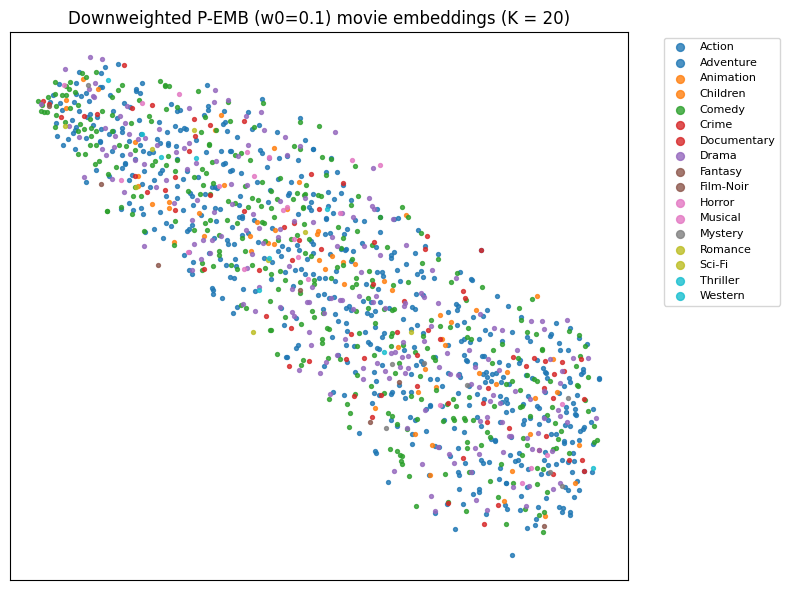

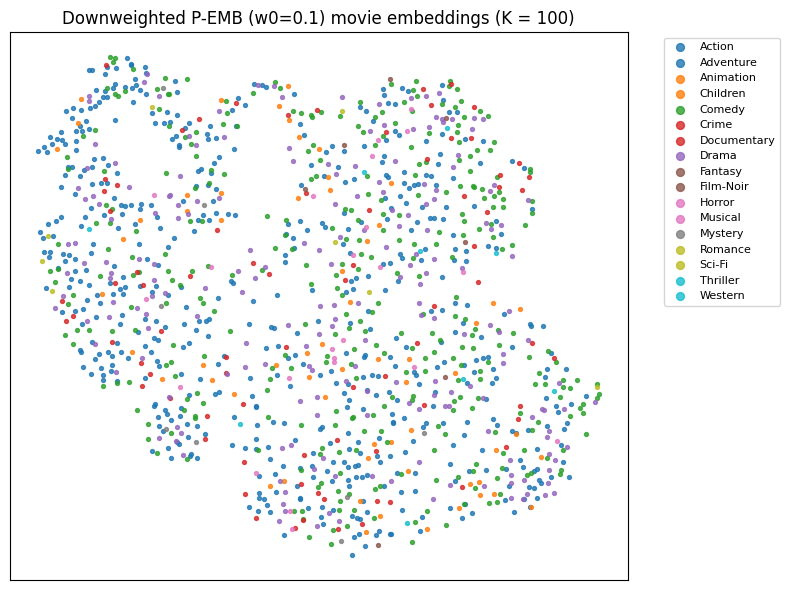

In [7]:
#STEP7
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib

# ------------ 0) Make sure movies_meta exists BEFORE training ------------

if "movies_meta" not in globals():
    print("movies_meta not found in globals() – rebuilding it from movies.csv and ratings.")

    if "ratings" not in globals():
        ratings_path = "ml-latest-small/ratings.csv"
        ratings = pd.read_csv(ratings_path)

    if "movie_id_to_idx" not in globals():
        unique_movies = ratings["movieId"].unique()
        movie_id_to_idx = {mid: i for i, mid in enumerate(sorted(unique_movies))}
        ratings["movie_idx"] = ratings["movieId"].map(movie_id_to_idx)

    movies_path = "ml-latest-small/movies.csv"
    movies = pd.read_csv(movies_path)

    movies["movie_idx"] = movies["movieId"].map(movie_id_to_idx)
    movies_meta = movies.dropna(subset=["movie_idx"]).copy()
    movies_meta["movie_idx"] = movies_meta["movie_idx"].astype(int)

    def get_primary_genre(genres):
        if not isinstance(genres, str):
            return "Unknown"
        if genres == "(no genres listed)":
            return "Unknown"
        return genres.split("|")[0]

    movies_meta["primary_genre"] = movies_meta["genres"].apply(get_primary_genre)

    movie_counts = ratings.groupby("movie_idx").size()
    movies_meta["num_ratings"] = movies_meta["movie_idx"].map(movie_counts).fillna(0).astype(int)

print("movies_meta is available. Example rows:")
display(movies_meta.head())

# ------------ 1) Prepare movie subset and color mapping ------------

min_ratings = 20   # you can increase to 40 to speed t-SNE if needed
movies_for_tsne = movies_meta[movies_meta["num_ratings"] >= min_ratings].copy()

movie_idx_arr = movies_for_tsne["movie_idx"].values
genres_arr    = movies_for_tsne["primary_genre"].values

print("Number of movies used in t-SNE:", len(movie_idx_arr))

unique_genres = sorted(movies_for_tsne["primary_genre"].unique())

# Use modern colormap API to avoid deprecation warnings
cmap = matplotlib.colormaps.get_cmap("tab10")
genre_to_color = {g: cmap(i / max(1, len(unique_genres) - 1)) for i, g in enumerate(unique_genres)}

# ------------ 2) Train downweighted P-EMB for K = 20 and K = 100 ------------

K_low  = 20   # baseline scale
K_high = 100  # high-capacity

print(f"\nTraining DOWNWEIGHTED P-EMB (w0=0.1) for K = {K_low}")
rho_dw_low, alpha_dw_low = train_pemb_downweighted(
    train_events=train_events,
    user_train_items=user_train_items,
    user_train_sets=user_train_sets,
    U=U,
    M=M,
    K=K_low,
    n_epochs=5,
    neg_per_pos=5,
    lr=0.05,
    reg=1e-4,
    w0=0.1,
    seed=42,
    verbose=True,
)

print(f"\nTraining DOWNWEIGHTED P-EMB (w0=0.1) for K = {K_high}")
rho_dw_high, alpha_dw_high = train_pemb_downweighted(
    train_events=train_events,
    user_train_items=user_train_items,
    user_train_sets=user_train_sets,
    U=U,
    M=M,
    K=K_high,
    n_epochs=5,
    neg_per_pos=5,
    lr=0.05,
    reg=1e-4,
    w0=0.1,
    seed=42,
    verbose=True,
)

# ------------ 3) Helper to run t-SNE and plot ------------

def plot_tsne_for_rho(rho, K, title_suffix=""):
    emb = rho[movie_idx_arr]  # (#movies, K)

    tsne = TSNE(
        n_components=2,
        perplexity=30,
        random_state=42,
        init="random",
    )
    coords = tsne.fit_transform(emb)

    plt.figure(figsize=(8, 6))
    for g in unique_genres:
        mask = (genres_arr == g)
        if mask.sum() == 0:
            continue
        plt.scatter(
            coords[mask, 0],
            coords[mask, 1],
            s=8,
            color=genre_to_color[g],
            label=g,
            alpha=0.8,
        )

    plt.title(f"Downweighted P-EMB (w0=0.1) movie embeddings (K = {K}){title_suffix}")
    plt.xticks([])
    plt.yticks([])
    plt.legend(
        markerscale=2,
        fontsize=8,
        bbox_to_anchor=(1.05, 1),
        loc="upper left",
    )
    plt.tight_layout()
    plt.show()

# ------------ 4) Generate the two t-SNE plots ------------

plot_tsne_for_rho(rho_dw_low,  K_low)    # t-SNE for K = 20
plot_tsne_for_rho(rho_dw_high, K_high)   # t-SNE for K = 100
